### 💻 **Cloud loud Billing and Usage Anomalies**

### 🎯 **Project Objective**

In this project, Detect unexpected spikes in cloud storage usage and billing anomalies that may arise due to errors or fraudulent behavior. By analyzing usage trends, we can detect discrepancies early, helping businesses like Backblaze to monitor and prevent unauthorized usage, unexpected charges, or resource overuse.

### 🧾 **Feature List**

In [1]:
feature_list = [
    'user_id',                             # Unique user identifier
    'login_frequency',                     # Frequency of logins per day
    'avg_session_duration',                # Average session duration (minutes)
    'failed_login_attempts',               # Number of failed login attempts
    'successful_login_attempts',           # Number of successful login attempts
    'ip_address',                          # IP address from which the user logged in
    'device_type',                         # Device type (e.g., mobile, desktop)
    'account_age_days',                    # Age of the account (in days)
    'total_storage_usage_GB',              # Total storage used by the user (in GB)
    'storage_increase_rate_GB_per_day',    # Rate at which the user's storage is increasing (in GB/day)
    'number_of_accounts_accessed',         # Number of accounts accessed within a short period
    'login_location',                      # Geographical location of the login (e.g., region/country)
    'login_time_of_day',                   # Time of the day when login occurred (e.g., morning, afternoon)
    'security_alerts',                     # Number of security alerts associated with the account
    'is_account_compromised'               # Target label: 0 for normal, 1 for compromised account
]


### 📦 **Step 1: Import Required Libraries**

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt


### 🧑‍💻 **Step 2: Generate Synthetic User Behavior Data**

In [3]:

# Generate synthetic data
def simulate_billing_data(num_samples):
    data = pd.DataFrame({
        'user_id': range(num_samples),
        'storage_usage_GB': np.random.uniform(1, 100, num_samples),  # Random storage usage in GB
        'billing_amount': np.random.uniform(5, 200, num_samples),  # Random billing amount in USD
        'daily_usage_rate': np.random.uniform(0.1, 5, num_samples),  # Daily usage rate in GB
        'num_active_days': np.random.randint(5, 30, num_samples),  # Random active days in a month
        'num_files_uploaded': np.random.randint(100, 10000, num_samples),  # Number of files uploaded
        'num_files_downloaded': np.random.randint(100, 10000, num_samples),  # Number of files downloaded
        'login_frequency': np.random.randint(5, 30, num_samples),  # Logins per month
        'account_type': ['premium' if i % 2 == 0 else 'free' for i in range(num_samples)],  # Account type
        'region': ['US' if i % 3 == 0 else 'EU' for i in range(num_samples)],  # Region
        'device_type': ['mobile' if i % 2 == 0 else 'desktop' for i in range(num_samples)],  # Device type
        'ip_address': ['192.168.1.' + str(i%255) for i in range(num_samples)],  # IP address
        'resource_usage_spike': np.random.choice([0, 1], num_samples)  # Simulate spikes in usage
    })
    return data

# Generate synthetic test data
test_data = simulate_billing_data(200)

# Inject anomalies (spikes in usage)
anomaly_indices = random.sample(range(len(test_data)), 10)  # Select random indices for anomalies
test_data.iloc[anomaly_indices, 1] += 50  # Inflate storage usage (GB)
test_data.iloc[anomaly_indices, 2] += 100  # Inflate billing amount
test_data.iloc[anomaly_indices, 5] += 500  # Inflate number of files uploaded

# Ensure that categorical features are properly encoded
test_data_encoded = test_data.copy()
test_data_encoded['account_type'] = test_data_encoded['account_type'].astype('category').cat.codes
test_data_encoded['region'] = test_data_encoded['region'].astype('category').cat.codes
test_data_encoded['device_type'] = test_data_encoded['device_type'].astype('category').cat.codes
test_data_encoded['ip_address'] = test_data_encoded['ip_address'].astype('category').cat.codes

# Double-check the data types after encoding
print(test_data_encoded.dtypes)

# Standardizing or scaling the test data (make sure all columns are numerical)
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(test_data_encoded.drop(columns=['user_id', 'resource_usage_spike']))

user_id                   int64
storage_usage_GB        float64
billing_amount          float64
daily_usage_rate        float64
num_active_days           int32
num_files_uploaded        int32
num_files_downloaded      int32
login_frequency           int32
account_type               int8
region                     int8
device_type                int8
ip_address                int16
resource_usage_spike      int32
dtype: object


In [4]:
test_data.head()

,user_id,storage_usage_GB,billing_amount,daily_usage_rate,num_active_days,num_files_uploaded,num_files_downloaded,login_frequency,account_type,region,device_type,ip_address,resource_usage_spike
0,0,105.466973,222.817479,3.394965,22,1694,577,9,premium,US,mobile,192.168.1.0,0
1,1,36.140245,34.935389,1.339052,21,1958,4099,25,free,EU,desktop,192.168.1.1,1
2,2,47.038659,137.292384,1.693280,25,6658,9666,17,premium,EU,mobile,192.168.1.2,0
3,3,66.534926,75.519398,0.850416,6,3569,9509,19,free,US,desktop,192.168.1.3,0
4,4,61.026373,85.128309,4.176407,24,6189,1819,22,premium,EU,mobile,192.168.1.4,0


### 🤖 **Step 3: Train the Model Using Isolation Forest**

In [5]:
model = IsolationForest(contamination=0.05)  # Assume 5% of data are anomalies
model.fit(test_data_scaled)

IsolationForest(contamination=0.05)

In [6]:
# Predict anomalies on the test data
test_data_encoded['predicted_anomaly'] = model.predict(test_data_scaled)
test_data_encoded['predicted_anomaly'] = test_data_encoded['predicted_anomaly'].map({1: 0, -1: 1})  # 0 for normal, 1 for anomaly

# Extract anomalies for inspection
anomalies = test_data_encoded[test_data_encoded['predicted_anomaly'] == 1]

# Display the detected anomalies
anomalies.head()

,user_id,storage_usage_GB,billing_amount,daily_usage_rate,num_active_days,num_files_uploaded,num_files_downloaded,login_frequency,account_type,region,device_type,ip_address,resource_usage_spike,predicted_anomaly
0,0,105.466973,222.817479,3.394965,22,1694,577,9,1,1,1,0,0,1
6,6,75.951395,173.268201,4.792073,29,302,6950,6,1,1,1,156,1,1
72,72,111.944491,274.973013,0.581163,19,3591,7193,8,1,1,1,170,0,1
96,96,4.775048,159.945889,4.823647,6,9524,5178,11,1,1,1,196,0,1
97,97,98.718468,29.569630,1.955517,28,2899,9227,28,0,0,0,197,0,1


### 📈 **Step 4: Plot Anomaly Scores Distribution**

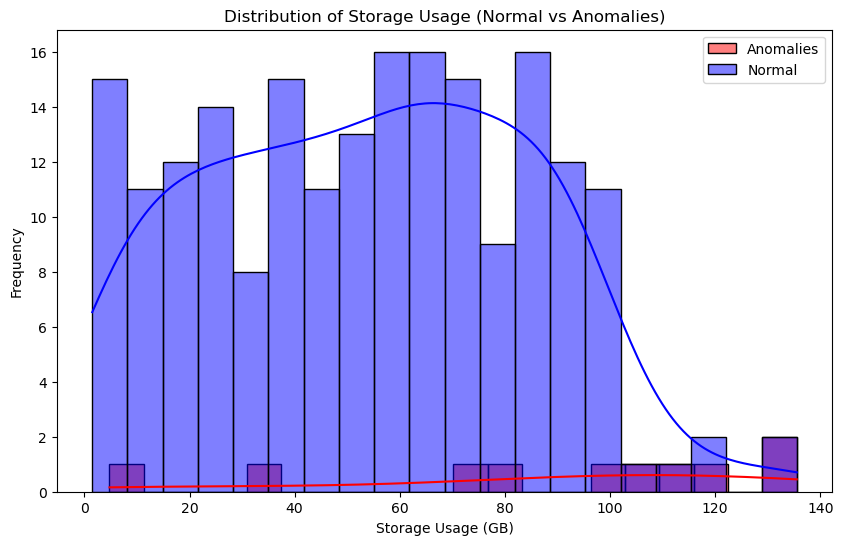

In [7]:
# Plot anomaly distribution
plt.figure(figsize=(10, 6))
sns.histplot(anomalies['storage_usage_GB'], bins=20, color='red', label="Anomalies", kde=True)
sns.histplot(test_data_encoded['storage_usage_GB'], bins=20, color='blue', label="Normal", kde=True)
plt.title("Distribution of Storage Usage (Normal vs Anomalies)")
plt.xlabel("Storage Usage (GB)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 📈 **Step 5: Evaluate Model Performance**

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       190
           1       0.00      0.00      0.00        10

    accuracy                           0.90       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.90      0.90      0.90       200



C:\Users\USER\AppData\Local\Temp\ipykernel_15100\1844835499.py:22: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


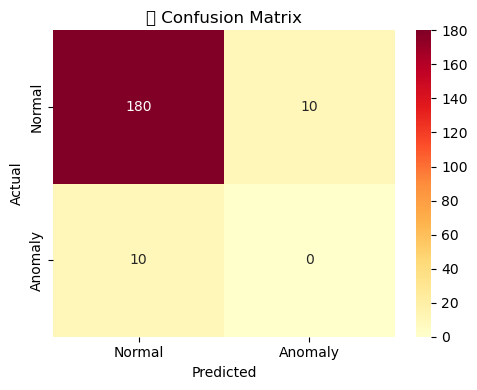

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

anomaly_indices = random.sample(range(len(test_data)), 10)

# Step 1: Create ground truth (true labels)
test_data_encoded['true_label'] = 0
test_data_encoded.loc[anomaly_indices, 'true_label'] = 1

# Step 2: Classification report
print("📊 Classification Report:")
print(classification_report(test_data_encoded['true_label'], test_data_encoded['predicted_anomaly']))

# Step 3: Confusion matrix
cm = confusion_matrix(test_data_encoded['true_label'], test_data_encoded['predicted_anomaly'])

# Step 4: Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("📉 Confusion Matrix")
plt.tight_layout()
plt.show()


In [9]:
# Export anomalies to CSV
anomalies.to_csv('anomalies_billing_usage.csv', index=False)